Important note: run the traditional methods first, before the changin the shape of the test dataset and using the autoencoder 

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
#discarding the labels
(train_images, _), (test_images, _) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Adding AWGN to all images in the testing dataset
# Initializing the gaussian noise
noise_level = 0.3
awgn = np.random.normal(0,noise_level,(28,28))
test_images_noisy = []
for i in range(len(test_images)):
  # normailizing and adding the gaussian nosie
  noised_img = (test_images[i]/255)+awgn
  # makeing sure that the noised image starts from 0
  noised_img = noised_img - noised_img.min()
  # making sure that the maximum value in the noised image is 1
  noised_img = noised_img/noised_img.max()
  # appending the nosied image
  test_images_noisy.append(noised_img)
test_images_noisy = np.array(test_images_noisy)
test_images_noisy = np.round(test_images_noisy*255).astype('uint8')

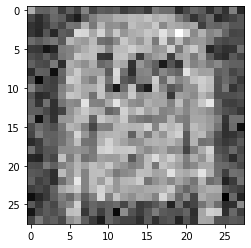

In [ ]:
plt.imshow(test_images_noisy[1], cmap='gray')

In [ ]:
train_images = train_images.astype('float32')/255
train_images = train_images.reshape((60000,28,28,1))
test_images = test_images.astype('float32')/255
test_images = test_images.reshape((10000,28,28,1))

In [ ]:

test_images_noisy_norm = test_images_noisy.astype('float32')/255
test_images_noisy_norm = test_images_noisy_norm.reshape((10000,28,28,1))

## Trying to increase the depth of the archtescture

In [ ]:
# In order to change the depth of the architecutre, I need to pad the input image to a certain dimention (ex: 32)
# So, I will be able to decrease its size further 

input_image  = Input(shape=(28,28,1))
x_c = GaussianNoise(0.3)(input_image)
h_1 = Conv2D(32, (3, 3), padding='same',activation='relu')(x_c)
p_1 = MaxPooling2D((3))(h_1)
h_2 = Conv2D(32, (3, 3), padding='same',activation='relu')(p_1)

p_11 = MaxPooling2D((2))(h_2)
h_22 = Conv2D(32, (3, 3), padding='same',activation='relu')(p_11)

z = MaxPooling2D((2))(h_22)

h_33 = Conv2DTranspose(32, (3, 3), padding='same',strides=(2), activation='relu')(z)

h_3 = Conv2DTranspose(32, (3, 3), padding='same',strides=(2), activation='relu')(h_33)
y = Conv2DTranspose(1, (3, 3), padding='same',strides=(2), activation='relu')(h_3)

#autoencoder = Model(input_image, decoded)
autoencoder = Model(input_image, y)

#autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#history = autoencoder.fit(train_images,train_images, epochs=25, batch_size=256,shuffle=True, validation_data=(test_images,test_images))






In [ ]:
autoencoder.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise_22 (GaussianN (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 4, 4, 32)        

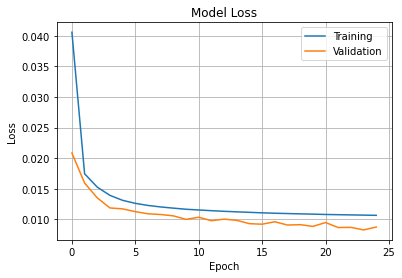

In [ ]:
#Visualize the models loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

decoded_test_images = autoencoder.predict(test_images)
#decoded_test_images = autoencoder.predict(test_images_noisy_norm)


CPU times: user 494 ms, sys: 56.9 ms, total: 551 ms
Wall time: 470 ms


In [ ]:

MSE = np.square(test_images - decoded_test_images).mean()
print('MSE = ' + str(round(MSE,5)))

MSE = 0.00874


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), decoded_test_images[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.81


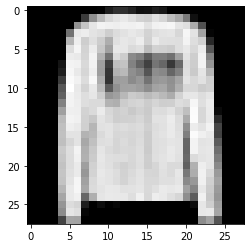

In [ ]:
plt.imshow(decoded_test_images[1].reshape(28,28), cmap='gray')

## Main architecture

In [ ]:
# without batch norm
input_image  = Input(shape=(28,28,1))
x_c = GaussianNoise(0.3)(input_image)
h_1 = Conv2D(32, (3, 3), padding='same',activation='relu')(x_c)

#h_1b = BatchNormalization()(h_1)

p_1 = MaxPooling2D((2, 2))(h_1)
h_2 = Conv2D(32, (3, 3), padding='same',activation='relu')(p_1)
#h_2b = BatchNormalization()(h_2)

z = MaxPooling2D((2, 2))(h_2)
h_3 = Conv2DTranspose(32, (3, 3), padding='same',strides=(2, 2), activation='relu')(z)
y = Conv2DTranspose(1, (3, 3), padding='same',strides=(2, 2), activation='relu')(h_3)

autoencoder = Model(input_image, y)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(train_images,train_images, epochs=25, batch_size=256, validation_split=0.2)



Epoch 1/25
188/188 [==============================] - 2s 12ms/step - loss: 0.0533 - val_loss: 0.0212
Epoch 2/25
188/188 [==============================] - 2s 11ms/step - loss: 0.0182 - val_loss: 0.0159
Epoch 3/25
188/188 [==============================] - 2s 11ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 4/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0142 - val_loss: 0.0124
Epoch 5/25
188/188 [==============================] - 2s 11ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 6/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0127 - val_loss: 0.0110
Epoch 7/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0123 - val_loss: 0.0109
Epoch 8/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 9/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 10/25
188/188 [==============================] - 2s 11ms/step - loss: 0.0114 - val_lo

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

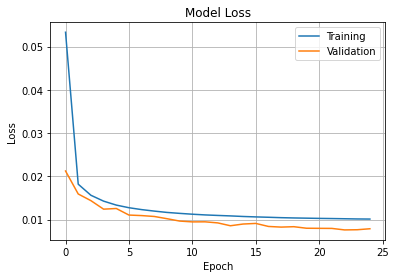

In [ ]:
#Visualize the models loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

decoded_test_images = autoencoder.predict(test_images)
#decoded_test_images = autoencoder.predict(test_images_noisy_norm)


CPU times: user 434 ms, sys: 46.9 ms, total: 481 ms
Wall time: 410 ms


In [ ]:

MSE = np.square(test_images - decoded_test_images).mean()
print('MSE = ' + str(round(MSE,5)))

MSE = 0.00789


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), decoded_test_images[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.83


## using bn

In [ ]:
# using bn (my model)
input_image  = Input(shape=(28,28,1), name='Input_Layer')
x_c = GaussianNoise(0.3)(input_image)
h_1 = Conv2D(32, (3, 3), padding='same',activation='relu', name='Conv_Layer_1')(x_c)

h_1b = BatchNormalization()(h_1)

p_1 = MaxPooling2D((2, 2))(h_1b)
h_2 = Conv2D(32, (3, 3), padding='same',activation='relu', name='Conv_Layer_2')(p_1)

h_2b = BatchNormalization()(h_2)

z = MaxPooling2D((2, 2))(h_2b)
h_3 = Conv2DTranspose(32, (3, 3), padding='same',strides=(2, 2), activation='relu', name='Conv_Transpose_Layer_1')(z)

#h_3b = BatchNormalization()(h_3)

y = Conv2DTranspose(1, (3, 3), padding='same',strides=(2, 2), activation='relu', name='Output_Layer')(h_3)

#autoencoder = Model(input_image, decoded)








In [ ]:
autoencoder = Model(input_image, y, name='Denoising_Autoencoder')


In [ ]:
#import tensorflow as tf
#tf.keras.utils.plot_model(autoencoder, to_file='DAE.png', show_shapes=True)



In [ ]:
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_Layer_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 3

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(train_images,train_images, epochs=25, batch_size=256, validation_split=0.2)

Epoch 1/25
188/188 [==============================] - 2s 10ms/step - loss: 0.0302 - val_loss: 0.1057
Epoch 2/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0146 - val_loss: 0.0487
Epoch 3/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0130 - val_loss: 0.0193
Epoch 4/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 5/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 6/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 7/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 8/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 9/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 10/25
188/188 [==============================] - 2s 9ms/step - loss: 0.0105 - val_loss: 0.008

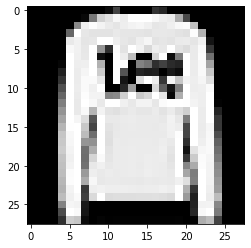

In [ ]:
plt.imshow(test_images[1].reshape(28,28), cmap='gray')

In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

decoded_test_images = autoencoder.predict(test_images)
#decoded_test_images = autoencoder.predict(test_images_noisy_norm)

CPU times: user 480 ms, sys: 46.1 ms, total: 526 ms
Wall time: 443 ms


In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

decoded_test_images = autoencoder.predict(test_images)
#decoded_test_images = autoencoder.predict(test_images_noisy_norm)

CPU times: user 590 ms, sys: 57.1 ms, total: 647 ms
Wall time: 560 ms


In [ ]:

MSE = np.square(test_images - decoded_test_images).mean()
print('MSE = ' + str(round(MSE,5)))

MSE = 0.00698


In [ ]:
psnr = 10*np.log10(255**2/MSE)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 69.7


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), decoded_test_images[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.84


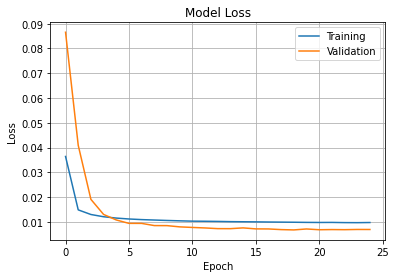

In [ ]:
#Visualize the models loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('Model_loss.png', bbox_inches='tight')


### Previous trial 

In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

decoded_test_images = autoencoder.predict(test_images)
#decoded_test_images = autoencoder.predict(test_images_noisy_norm)


CPU times: user 445 ms, sys: 32.9 ms, total: 478 ms
Wall time: 414 ms


In [ ]:

MSE = np.square(test_images - decoded_test_images).mean()
print('MSE = ' + str(round(MSE,5)))

MSE = 0.00691


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), decoded_test_images[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.83


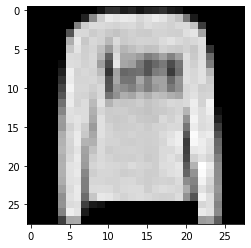

In [ ]:
plt.imshow(decoded_test_images[1].reshape(28,28), cmap='gray')

## using SSIM

In [ ]:
# using the ssim loss
import tensorflow as tf

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

input_image  = Input(shape=(28,28,1))
x_c = GaussianNoise(0.3)(input_image)
h_1 = Conv2D(64, (3, 3), padding='same',activation='relu')(x_c)
h_1b = BatchNormalization()(h_1)

p_1 = MaxPooling2D((2, 2))(h_1b)
h_2 = Conv2D(32, (3, 3), padding='same',activation='relu')(p_1)
h_2b = BatchNormalization()(h_2)

z = MaxPooling2D((2, 2))(h_2b)
h_3 = Conv2DTranspose(64, (3, 3), padding='same',strides=(2, 2), activation='relu')(z)
h_3b = BatchNormalization()(h_3)

y = Conv2DTranspose(1, (3, 3), padding='same',strides=(2, 2), activation='sigmoid')(h_3b)

#autoencoder = Model(input_image, decoded)
autoencoder = Model(input_image, y)




In [ ]:
#autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='adam', loss=SSIMLoss)

history = autoencoder.fit(train_images,train_images, epochs=10, batch_size=256,shuffle=True, validation_data=(test_images,test_images))

Epoch 1/10
235/235 [==============================] - 8s 34ms/step - loss: 0.3960 - val_loss: 0.7843
Epoch 2/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2906 - val_loss: 0.4228
Epoch 3/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2731 - val_loss: 0.2602
Epoch 4/10
235/235 [==============================] - 8s 32ms/step - loss: 0.2671 - val_loss: 0.2521
Epoch 5/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2633 - val_loss: 0.2549
Epoch 6/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2610 - val_loss: 0.2509
Epoch 7/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2590 - val_loss: 0.2308
Epoch 8/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2579 - val_loss: 0.2330
Epoch 9/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2565 - val_loss: 0.2287
Epoch 10/10
235/235 [==============================] - 7s 32ms/step - loss: 0.2556 - val_lo

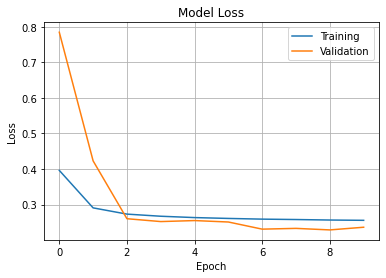

In [ ]:
#Visualize the models loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
%%time
# encode and decode some digits
# note that we take them from the *test* set

#decoded_test_images = autoencoder.predict(test_images)
decoded_test_images = autoencoder.predict(test_images_noisy_norm)


CPU times: user 638 ms, sys: 74.3 ms, total: 713 ms
Wall time: 729 ms


In [ ]:

MSE = np.square(test_images - decoded_test_images).mean()
print('MSE = ' + str(round(MSE,5)))

MSE = 0.10231


In [ ]:
psnr = 10*np.log10(255**2/MSE)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 69.23


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), decoded_test_images[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.28


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i].reshape(28,28), test_images_noisy_norm[i].reshape(28,28))
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.37


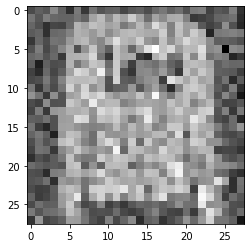

In [ ]:
plt.imshow(test_images_noisy[1].reshape(28,28), cmap='gray')

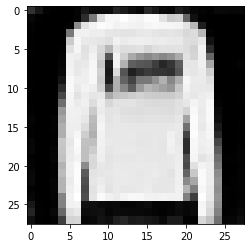

In [ ]:
plt.imshow(decoded_test_images[1].reshape(28,28), cmap='gray')

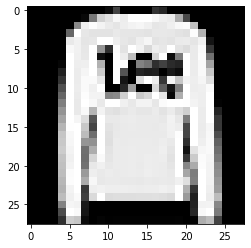

In [ ]:
plt.imshow(test_images[1].reshape(28,28), cmap='gray')

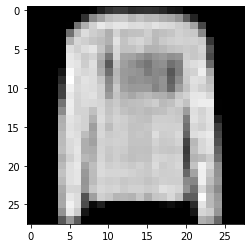

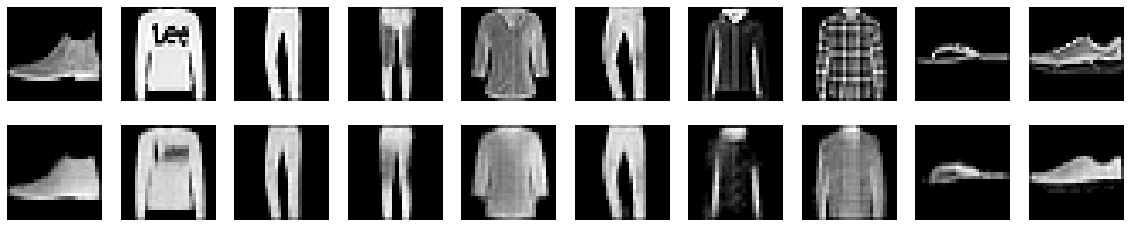

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")
    # display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_images[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")
plt.show()

# Mean filter

In [ ]:
import cv2
from skimage.restoration import denoise_nl_means


In [ ]:
# Applying the mean filter and measuring the excution time
# Non-local Means Denoising algorithm http://www.ipol.im/pub/algo/bcm_non_local_means_denoising
# https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga4c6b0031f56ea3f98f768881279ffe93
%%time

test_images_denoised_mean = []
for i in range(len(test_images_noisy)):
    #dst = cv2.fastNlMeansDenoising(np.round(noisy*255).astype('uint8'), None, h=15)
    denoised_image = cv2.fastNlMeansDenoising(test_images_noisy[i], None, h=20)
    test_images_denoised_mean.append(denoised_image)


CPU times: user 57.8 s, sys: 0 ns, total: 57.8 s
Wall time: 57.8 s


In [ ]:
# Applying the mean filter and measuring the excution time
# Non-local Means Denoising algorithm http://www.ipol.im/pub/algo/bcm_non_local_means_denoising
# https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga4c6b0031f56ea3f98f768881279ffe93
%%time

test_images_denoised_mean = []
for i in range(len(test_images_noisy)):
    #dst = cv2.fastNlMeansDenoising(np.round(noisy*255).astype('uint8'), None, h=15)
    denoised_image = cv2.fastNlMeansDenoising(test_images_noisy[i], None, h=20)
    test_images_denoised_mean.append(denoised_image)



CPU times: user 1min 3s, sys: 8.97 ms, total: 1min 3s
Wall time: 1min 3s


In [ ]:
# h=20
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i], test_images_denoised_mean[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 7778.15


In [ ]:
psnr = 10*np.log10(255**2/mse_mean)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 9.22


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i], test_images_denoised_mean[i])
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.34


# Median filter

In [ ]:
from scipy import ndimage


In [ ]:
%%time

test_images_denoised_median = []
for i in range(len(test_images_noisy)):
    denoised_image = ndimage.median_filter(test_images_noisy[i], 3)
    test_images_denoised_median.append(denoised_image)

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.63 s


In [ ]:
%%time

test_images_denoised_median = []
for i in range(len(test_images_noisy)):
    denoised_image = ndimage.median_filter(test_images_noisy[i], 3)
    test_images_denoised_median.append(denoised_image)

CPU times: user 1.58 s, sys: 915 µs, total: 1.58 s
Wall time: 1.58 s


In [ ]:
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i], test_images_denoised_median[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 5452.06


In [ ]:
psnr = 10*np.log10(255**2/mse_mean)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 10.77


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i], test_images_denoised[i])
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.31


# Wavelet

In [ ]:
from skimage.restoration import denoise_wavelet, estimate_sigma



In [ ]:
%%time

test_images_denoised_wvlt_bs = []
for i in range(len(test_images_noisy)):
    #sigma_est = estimate_sigma(test_images_noisy[i])
    denoised_image = denoise_wavelet(test_images_noisy[i], method='BayesShrink', mode='soft', rescale_sigma=True)
    test_images_denoised_wvlt_bs.append(denoised_image)

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 7.74 s


In [ ]:
%%time

test_images_denoised = []
for i in range(len(test_images_noisy)):
    #sigma_est = estimate_sigma(test_images_noisy[i])
    denoised_image = denoise_wavelet(test_images_noisy[i], method='BayesShrink', mode='soft', rescale_sigma=True)
    test_images_denoised.append(denoised_image)

CPU times: user 8.32 s, sys: 2.09 ms, total: 8.32 s
Wall time: 8.34 s


In [ ]:
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i]/255, test_images_denoised[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 0.09


In [ ]:
psnr = 10*np.log10(255**2/mse_mean)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 58.53


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i]/255, test_images_denoised[i])
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.4


In [ ]:
%%time

test_images_denoised_wvlt_vs = []
for i in range(len(test_images_noisy)):
    #sigma_est = estimate_sigma(test_images_noisy[i])
    denoised_image = denoise_wavelet(test_images_noisy[i], method='VisuShrink', mode='soft', rescale_sigma=True)
    test_images_denoised_wvlt_vs.append(denoised_image)

CPU times: user 7.38 s, sys: 0 ns, total: 7.38 s
Wall time: 7.39 s


In [ ]:
%%time

test_images_denoised = []
for i in range(len(test_images_noisy)):
    #sigma_est = estimate_sigma(test_images_noisy[i])
    denoised_image = denoise_wavelet(test_images_noisy[i], method='VisuShrink', mode='soft', rescale_sigma=True)
    test_images_denoised.append(denoised_image)

CPU times: user 7.54 s, sys: 18.3 ms, total: 7.56 s
Wall time: 7.56 s


In [ ]:
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i]/255, test_images_denoised[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 0.09


In [ ]:
psnr = 10*np.log10(255**2/mse_mean)
print('PSNR = ' + str(round(psnr,2)))

PSNR = 58.37


In [ ]:
ssim_list = []
for i in range(len(test_images)):
    ssim = structural_similarity(test_images[i]/255, test_images_denoised[i])
    ssim_list.append(ssim)
ssim_mean = np.array(ssim_list).mean()
print('SSIM = ' + str(round(ssim_mean,2)))

SSIM = 0.36


# plotting

In [ ]:
# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

In [ ]:
decoded_test_images.shape

(10000, 28, 28, 1)

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")
    # display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_images[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")
plt.show()

In [ ]:
test_images.shape

(10000, 28, 28, 1)

<Figure size 432x288 with 0 Axes>

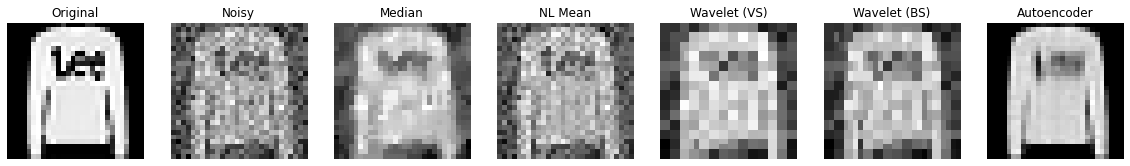

In [ ]:
i=1

plt.figure(figsize=(20, 4))
plt.subplot(1,7,1)
plt.imshow(test_images[i].reshape(28,28), cmap='gray')
plt.title('Original')
plt.axis("off")

plt.subplot(1,7,2)
plt.imshow(test_images_noisy[i], cmap='gray')
plt.title('Noisy')
plt.axis("off")

plt.subplot(1,7,3)
plt.imshow(test_images_denoised_median[i], cmap='gray')
plt.title('Median')
plt.axis("off")

plt.subplot(1,7,4)
plt.imshow(test_images_denoised_mean[i], cmap='gray')
plt.title('NL Mean')
plt.axis("off")

plt.subplot(1,7,5)
plt.imshow(test_images_denoised_wvlt_vs[i], cmap='gray')
plt.title('Wavelet (VS)')
plt.axis("off")

plt.subplot(1,7,6)
plt.imshow(test_images_denoised_wvlt_bs[i], cmap='gray')
plt.title('Wavelet (BS)')
plt.axis("off")

plt.subplot(1,7,7)
plt.imshow(decoded_test_images[i].reshape(28,28), cmap='gray')
plt.title('Autoencoder')
plt.axis("off")

plt.savefig('Images.png', bbox_inches='tight')



# Total variation loss

In [ ]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral


In [ ]:
%%time

test_images_denoised = []
for i in range(len(test_images_noisy)):
    denoised_image = denoise_tv_chambolle(test_images_noisy[i], weight=0.1)
    test_images_denoised.append(denoised_image)

CPU times: user 14.1 s, sys: 992 µs, total: 14.1 s
Wall time: 14.1 s


In [ ]:
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i]/255, test_images_denoised[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 0.07


# Bilateral

In [ ]:
%%time

test_images_denoised = []
for i in range(len(test_images_noisy)):
    denoised_image = denoise_bilateral(test_images_noisy[i], sigma_color=0.05, sigma_spatial=15)
    test_images_denoised.append(denoised_image)

CPU times: user 18min 48s, sys: 157 ms, total: 18min 49s
Wall time: 18min 49s


In [ ]:
mse_list = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i]/255, test_images_denoised[i])
    mse_list.append(mse)
mse_mean = np.array(mse_list).mean()
print('MSE = ' + str(round(mse_mean,2)))

MSE = 0.06
